In [4]:
from TwitterAPI import TwitterAPI, TwitterPager
import requests_cache
import time
import csv
import pandas as pd
import pickle
import re
import nltk
import nltk.corpus
import json
import numpy as np
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import wordnet
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem.snowball import SnowballStemmer
import pyLDAvis
plt.rcParams["figure.figsize"] = [10, 8]

In [4]:
consumer_key = "z6VGZHRGNwybqWyonTN2QDKb7"
consumer_secret = "j3MatsgQyn7G48RXyjxkbOKpd4TE2QxTNRLiZg0AubEuK63ER2"
access_token_key = '955033387-u84QPMj9J1pACjcoa369HW3EAwO6NAdC2IwKITE0'
access_token_secret = 'EQwqi2xaCZEWJnhB6dChearbmem4HlMfQHtewQoidCzYu'

# make the connection
api = TwitterAPI(consumer_key, consumer_secret, access_token_key, access_token_secret)

In [52]:
#https://github.com/geduldig/TwitterAPI/blob/master/examples/premium_search.py
#https://developer.twitter.com/en/docs/tweets/search/api-reference/premium-search
#https://stackoverflow.com/questions/50724765/how-to-retrieve-all-historical-public-tweets-with-twitter-premium-search-api-in

SEARCH_TERM = 'California Camp Fire'
PRODUCT = '30day'
LABEL = '30day'

pager = TwitterPager(api, 'tweets/search/%s/:%s' % (PRODUCT, LABEL),
                     {'query':SEARCH_TERM})

thirty_days = [{
    "Post_date":      item['created_at'],
    "User":           item['user']['screen_name'],
    "Quote_Count":    item['quote_count'],
    "Reply_Count":    item['reply_count'],
    "Retweet_Count":  item['retweet_count'],
    "Favorite_Count": item['favorite_count'],
    "Location":       item['user']['location'],
    "Text":           item['text']
} for item in pager.get_iterator() if 'text' in item]

#csvFile.close()

In [58]:
thirty_days_df = pd.DataFrame(thirty_days)
thirty_days_df

,Favorite_Count,Location,Post_date,Quote_Count,Reply_Count,Retweet_Count,Text,User
0,0,"Abu Dhabi, United Arab Emirates",Wed Mar 06 06:07:34 +0000 2019,0,0,0,RT @cnnbrk: Pacific Gas &amp; Electric says it...,saeed_m_alshams
1,0,"Paso Robles, CA",Wed Mar 06 04:10:04 +0000 2019,0,0,0,RT @Bewickwren: California Wildfires On The Sc...,CalDisasters
2,0,New Mexico USA,Wed Mar 06 04:06:53 +0000 2019,0,0,1,California Wildfires On The Scale Of Camp Fire...,Bewickwren
3,0,Philippines,Wed Mar 06 03:11:18 +0000 2019,0,0,0,California Wildfires On The Scale Of Camp Fire...,iiradned
4,0,"Enterprise, Al",Wed Mar 06 03:05:06 +0000 2019,0,0,0,California Wildfires On The Scale Of Camp Fire...,Kay_Z_18
5,0,Virginia,Wed Mar 06 02:56:53 +0000 2019,0,0,0,RT @AnimalBandon: This is what we just sent to...,Billylittlebit
6,0,"Central Harlem, Manhattan",Wed Mar 06 02:01:43 +0000 2019,0,0,0,RT @cnnbrk: Pacific Gas &amp; Electric says it...,Limeylizzie
7,0,"Antelope, California, USA",Wed Mar 06 02:00:39 +0000 2019,0,0,0,PG&amp;E is risky but I am saying to buy it so...,JamesPup
8,0,NZ . East BOP,Wed Mar 06 02:00:12 +0000 2019,0,0,0,RT @cnnbrk: Pacific Gas &amp; Electric says it...,transparency_a1
9,0,Italia,Wed Mar 06 01:25:29 +0000 2019,0,0,0,RT @usatodayvideo: A dog returns home 101 days...,dtm96_usa


In [59]:
thirty_days_df.to_pickle("thirty_days.txt")

In [303]:
thirty_days_df = pd.read_pickle("thirty_days.txt")

In [407]:
def wordnet_pos(tag):
    """Map a Brown POS tag to a WordNet POS tag."""
    
    table = {"N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV, "J": wordnet.ADJ}
    
    # Default to a noun.
    return table.get(tag[0], wordnet.NOUN)

def corpus_cleaner(text):
    """
    Performs basic corpus cleaning by performing tokenization, lowercasing, removing non-words
    removing stop-words, and lemmatizing. Returns a list of the cleaned text
    
    text: an article dataframe as described in Excercise 1.3
    """
    #Tokenize the words
    words = [nltk.word_tokenize(x) for x in text["text"]]

    #https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-list-of-lists
    #Flatten the list of lists
    words = [item for sublist in words for item in sublist]

    #lowercase words and remove non-words
    lower = [w.lower() for w in words if (re.search("[0-9:\\.`'“’(),”\-@—&;$#!\*\+\?_/]|\\\\u[0-9]+|https|\\bamp\\b|\\brt\\b", w) is None) and re.search("[a-zA-Z]", w)]

    #Init lemmatizer and stopword dict
    lemmatizer = nltk.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words("english")

    #Lemmatize and remove stopwords
    article_tags = nltk.pos_tag(lower)
    cleaned = [lemmatizer.lemmatize(w, wordnet_pos(t)) for (w, t) in article_tags if w not in stopwords]
    return(cleaned)

In [246]:
cleaned_thirty_days = corpus_cleaner(thirty_days_df)

In [247]:
cleaned_thirty_days

['rt',
 'cnnbrk',
 'pacific',
 'gas',
 'electric',
 'say',
 'probable',
 'equipment',
 'find',
 'ignition',
 'point',
 'last',
 'year',
 'camp',
 'fi…',
 'rt',
 'bewickwren',
 'california',
 'wildfire',
 'scale',
 'camp',
 'fire',
 'could',
 'happen',
 'year',
 'say',
 'proceeding',
 'national',
 'academy',
 'scien…',
 'california',
 'wildfire',
 'scale',
 'camp',
 'fire',
 'could',
 'happen',
 'year',
 'say',
 'proceeding',
 'national',
 'academy…',
 'california',
 'wildfire',
 'scale',
 'camp',
 'fire',
 'could',
 'happen',
 'year',
 'scientist',
 'say',
 'via',
 'iflscience',
 'california',
 'wildfire',
 'scale',
 'camp',
 'fire',
 'could',
 'happen',
 'year',
 'scientist',
 'say',
 'rt',
 'animalbandon',
 'send',
 'concow',
 'butte',
 'county',
 'california',
 'day',
 'camp',
 'fire',
 'november',
 'bandon',
 'an…',
 'rt',
 'cnnbrk',
 'pacific',
 'gas',
 'electric',
 'say',
 'probable',
 'equipment',
 'find',
 'ignition',
 'point',
 'last',
 'year',
 'camp',
 'fi…',
 'pg',
 'e',
 '

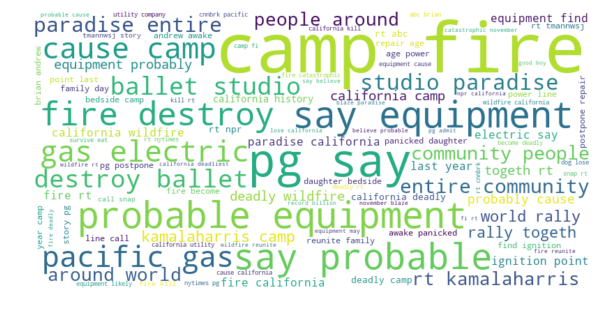

In [240]:
doc = ' '.join(cleaned_thirty_days)
wordcloud = WordCloud(width = 800, 
                      height = 400, 
                      max_font_size = 100,
                      max_words = 100,
                     background_color = "white").generate(doc)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

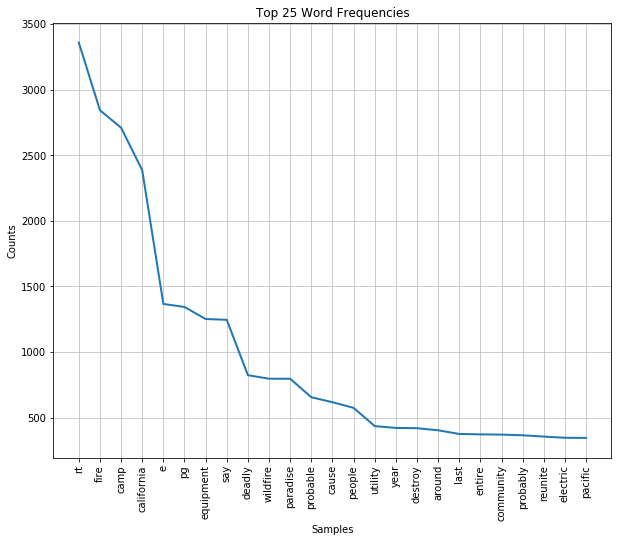

In [248]:
fq = nltk.FreqDist(w for w in cleaned_thirty_days)
fq.plot(25, title = "Top 25 Word Frequencies")

In [394]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search("[0-9:\\.`'“’(),”\-@—&;$#!/]|https|\\bamp\\b", token) is None:
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if (re.search("[0-9:\\.`'“’(),”\-@—&;$#!\*\+\?_/\\\\]|https|\\bamp\\b|rt", token) is None) and re.search("[a-zA-Z]", token):
            filtered_tokens.append(token)
    return filtered_tokens

In [232]:
stemmer = SnowballStemmer("english")
tfidf_vectorizer = TfidfVectorizer(tokenizer = tokenize_only, 
                                   stop_words='english', 
                                   sublinear_tf = True)
tfidf = tfidf_vectorizer.fit_transform(thirty_days_df["Text"].tolist())
tfidf

<4794x3241 sparse matrix of type '<class 'numpy.float64'>'
	with 51125 stored elements in Compressed Sparse Row format>

In [233]:
#Get the consine similarity
dist = 1 - cosine_similarity(tfidf)
dist

array([[-2.22044605e-16,  9.11606564e-01,  8.95509850e-01, ...,
         9.92073613e-01,  9.91033904e-01,  9.91154934e-01],
       [ 9.11606564e-01,  0.00000000e+00,  3.40572227e-01, ...,
         9.95563988e-01,  9.89140503e-01,  9.95049849e-01],
       [ 8.95509850e-01,  3.40572227e-01,  0.00000000e+00, ...,
         9.94756177e-01,  9.87162955e-01,  9.94148411e-01],
       ...,
       [ 9.92073613e-01,  9.95563988e-01,  9.94756177e-01, ...,
         0.00000000e+00,  9.95636878e-01,  9.95695774e-01],
       [ 9.91033904e-01,  9.89140503e-01,  9.87162955e-01, ...,
         9.95636878e-01, -2.22044605e-16,  9.95131187e-01],
       [ 9.91154934e-01,  9.95049849e-01,  9.94148411e-01, ...,
         9.95695774e-01,  9.95131187e-01,  0.00000000e+00]])

In [234]:
tfidf_vectorizer.get_feature_names()

['abbia',
 'abc',
 'abcactionnews',
 'abcworldnews',
 'abnormal',
 'absolutely',
 'abv',
 'ab…',
 'academy',
 'academy…',
 'accelerated',
 'accepts',
 'access',
 'accfb',
 'accommodate',
 'according',
 'according…',
 'accusing',
 'acknowledged',
 'acknowledged…',
 'acknowledges',
 'acknowledge…',
 'acknowledg…',
 'acknow…',
 'ackno…',
 'acquaintances…',
 'acres',
 'acrid',
 'action',
 'active',
 'actual',
 'adamlevine',
 'adaptation',
 'add',
 'added',
 'additional',
 'address',
 'addressed',
 'admission',
 'admit',
 'admits',
 'admitted',
 'admitting',
 'admit…',
 'adoption',
 'adorns',
 'adrian',
 'adviseagainstit',
 'affai…',
 'affected',
 'affects',
 'afford',
 'afghan',
 'aftermath',
 'afterward',
 'after…',
 'afte…',
 'against…',
 'agencies',
 'agency',
 'aging',
 'ago',
 'ahora',
 'aid',
 'aide',
 'air',
 'aire',
 'akchangtwit',
 'akita',
 'al',
 'alabama',
 'alarm',
 'alastairgee',
 'album',
 'alexcessive',
 'alexckaufman',
 'alfredgockel',
 'algal',
 'alive',
 'alle',
 'allege

In [235]:
tfidf_vectorizer = TfidfVectorizer(tokenizer = tokenize_only, 
                                   min_df = 0.05,
                                   stop_words='english', 
                                   sublinear_tf = True,
                                  ngram_range = (2,2))
tfidf = tfidf_vectorizer.fit_transform(thirty_days_df["Text"].tolist())
tfidf_vectorizer.get_feature_names()

['ballet studio',
 'california s',
 'camp deadliest',
 'camp destroyed',
 'caused camp',
 'community people',
 'deadliest wildfire',
 'destroyed ballet',
 'e said',
 'e says',
 'electric says',
 'entire community',
 'equipment probably',
 'gas electric',
 'ignition point',
 'kamalaharris camp',
 'pacific gas',
 'paradise california',
 'paradise entire',
 'people world',
 'pg e',
 'probable equipment',
 'probably caused',
 'rallied togeth…',
 'says equipment',
 'says probable',
 'studio paradise',
 'world rallied']

In [299]:
ids = ['Tweet {0}'.format(i) for i in thirty_days_df.index]
#df_with_ids = thirty_days_df.set_index(pd.Series(ids).values)
df_with_ids = thirty_days_df.assign(title=pd.Series(ids).values)

df_with_ids["source"] = "Twitter"

d = {'text' : df_with_ids["Text"], 'title' : ids, 'source' : df_with_ids["source"]}
only_ids = pd.DataFrame(d)
only_ids.to_pickle("tweets_with_id.txt")


In [289]:
only_ids

,text,title,source
0,RT @cnnbrk: Pacific Gas &amp; Electric says it...,Tweet 0,Twitter
1,RT @Bewickwren: California Wildfires On The Sc...,Tweet 1,Twitter
2,California Wildfires On The Scale Of Camp Fire...,Tweet 2,Twitter
3,California Wildfires On The Scale Of Camp Fire...,Tweet 3,Twitter
4,California Wildfires On The Scale Of Camp Fire...,Tweet 4,Twitter
5,RT @AnimalBandon: This is what we just sent to...,Tweet 5,Twitter
6,RT @cnnbrk: Pacific Gas &amp; Electric says it...,Tweet 6,Twitter
7,PG&amp;E is risky but I am saying to buy it so...,Tweet 7,Twitter
8,RT @cnnbrk: Pacific Gas &amp; Electric says it...,Tweet 8,Twitter
9,RT @usatodayvideo: A dog returns home 101 days...,Tweet 9,Twitter


In [276]:
sampled = df_with_ids.sample(n=90)
sampled

,Favorite_Count,Location,Post_date,Quote_Count,Reply_Count,Retweet_Count,Text,User
Tweet 269,0,"Mesa, AZ",Fri Mar 01 22:46:03 +0000 2019,0,0,0,RT @BMSG: PG&amp;E says it probably caused the...,SafeH2o4Schools
Tweet 93,0,None,Mon Mar 04 16:10:30 +0000 2019,0,0,0,@realDonaldTrump @GovIvey The Camp Fire the de...,swampydoodle
Tweet 1704,0,"Sacramento, CA",Thu Feb 28 17:41:46 +0000 2019,0,0,0,RT @dakasler: BREAKING - PG&amp;E says equipme...,ayoonhendricks
Tweet 1896,0,"Austin, TX",Thu Feb 28 16:31:01 +0000 2019,0,0,0,RT @nytimes: PG&amp;E said that its equipment ...,TracyCluck
Tweet 2739,0,Baton Rouge,Thu Feb 21 03:28:03 +0000 2019,0,0,0,Camp Fire Cats Rocks! Dog reunited with famil...,juli882
Tweet 688,1,"Yuma, AZ/El Centro, CA",Fri Mar 01 04:29:42 +0000 2019,0,0,0,Pacific Gas &amp; Electric acknowledged Thursd...,13OnYourSide
Tweet 2880,0,"Arlington, VA",Wed Feb 20 18:04:58 +0000 2019,0,0,0,"RT @timkmak: Kingston, a 12 year old dog lost ...",LizMair
Tweet 3623,0,Brumado - BA. - BRASIL,Mon Feb 11 01:59:13 +0000 2019,0,0,0,RT @ABC: Brian Andrews awoke on Nov. 8 to his ...,Robsonetlima
Tweet 3422,0,"Spring Hill, FL",Wed Feb 13 02:15:14 +0000 2019,0,0,0,RT @consciouscats: The news cycle has moved on...,gmama33
Tweet 3736,0,None,Sun Feb 10 20:58:58 +0000 2019,0,0,0,RT @KamalaHarris: When the Camp Fire destroyed...,SheralynDuncum


In [277]:
stemmer = SnowballStemmer("english")
tfidf_vectorizer = TfidfVectorizer(tokenizer = tokenize_only, 
                                   stop_words='english', 
                                   sublinear_tf = True)
tfidf = tfidf_vectorizer.fit_transform(sampled["Text"].tolist())
tfidf

dist = 1 - cosine_similarity(tfidf)
dist

array([[-2.22044605e-16,  9.77847397e-01,  6.48152511e-01, ...,
         9.40484643e-01,  9.27237193e-01,  9.62610315e-01],
       [ 9.77847397e-01,  0.00000000e+00,  9.80903595e-01, ...,
         1.00000000e+00,  1.00000000e+00,  8.09328127e-01],
       [ 6.48152511e-01,  9.80903595e-01, -2.22044605e-16, ...,
         8.63727049e-01,  9.35680461e-01,  1.00000000e+00],
       ...,
       [ 9.40484643e-01,  1.00000000e+00,  8.63727049e-01, ...,
         0.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       [ 9.27237193e-01,  1.00000000e+00,  9.35680461e-01, ...,
         1.00000000e+00,  2.22044605e-16,  1.00000000e+00],
       [ 9.62610315e-01,  8.09328127e-01,  1.00000000e+00, ...,
         1.00000000e+00,  1.00000000e+00,  0.00000000e+00]])

In [278]:
list(sampled.index)

['Tweet 269',
 'Tweet 93',
 'Tweet 1704',
 'Tweet 1896',
 'Tweet 2739',
 'Tweet 688',
 'Tweet 2880',
 'Tweet 3623',
 'Tweet 3422',
 'Tweet 3736',
 'Tweet 830',
 'Tweet 4132',
 'Tweet 1796',
 'Tweet 3137',
 'Tweet 3096',
 'Tweet 284',
 'Tweet 451',
 'Tweet 2949',
 'Tweet 4113',
 'Tweet 52',
 'Tweet 1017',
 'Tweet 1125',
 'Tweet 3701',
 'Tweet 2271',
 'Tweet 1689',
 'Tweet 2414',
 'Tweet 4753',
 'Tweet 3473',
 'Tweet 2892',
 'Tweet 2445',
 'Tweet 2737',
 'Tweet 3102',
 'Tweet 3198',
 'Tweet 342',
 'Tweet 1309',
 'Tweet 16',
 'Tweet 1468',
 'Tweet 2136',
 'Tweet 3517',
 'Tweet 2075',
 'Tweet 4175',
 'Tweet 2789',
 'Tweet 1419',
 'Tweet 2228',
 'Tweet 11',
 'Tweet 2276',
 'Tweet 801',
 'Tweet 988',
 'Tweet 3889',
 'Tweet 839',
 'Tweet 2093',
 'Tweet 3514',
 'Tweet 4505',
 'Tweet 897',
 'Tweet 650',
 'Tweet 4242',
 'Tweet 3084',
 'Tweet 1153',
 'Tweet 3142',
 'Tweet 2359',
 'Tweet 2549',
 'Tweet 3470',
 'Tweet 3504',
 'Tweet 354',
 'Tweet 946',
 'Tweet 1508',
 'Tweet 3518',
 'Tweet 1467',
 

In [306]:
articles_gn = pd.read_pickle("articles_gn.txt")
paradise_merge = pd.read_pickle("paradise_merge.txt")
only_ids = pd.read_pickle("tweets_with_id.txt")

all_df = articles_gn.append([paradise_merge, only_ids])
all_df

,text,title,source
0,"California wildfires are raging this summer, b...",California Fires Map: Get the Latest Updates f...,Google News
1,"California wildfires are burning again, with t...","California Fires: Wildfires Map for Camp, Wool...",Google News
2,"Corrected, Dec. 12., 3:05p.m. ET\n\nFollowing ...",35 Paradise Families Sue PG&E Over California'...,Google News
3,It’s one thing to read about the massive devas...,Heartbreaking 360-Degree Film Shows Aftermath ...,Google News
4,PG&E is restructuring its board following the ...,PG&E Board of Directors Is Restructuring After...,Google News
5,Butte County and California State Parks announ...,"Butte County, California State Parks provide t...",Google News
6,"Tuesday, Cal OES said they, along with FEMA, t...",Cal OES: There is no need for a temporary debr...,Google News
7,Camp Fire survivor Ralph Castro and his family...,Camp Fire survivor moving to New York as victi...,Google News
8,Camp Fire survivors gathered at the Calvary Ch...,Camp Fire debris removal questions answered at...,Google News
9,KRCR News Channel 7's Chief Meteorologist Mike...,Camp Fire Map: Mike Krueger gives an in depth ...,Google News


In [307]:
all_df.to_pickle("all_df.txt")

In [310]:
all_df_sample

text  \
0 165   SUPER SALE: $3 for 3 months of Digital Plus Th...   
  130   Photo: AP\n\nMiraculously, the number of dead ...   
  99    It’s winter and that means most of us have our...   
  70    William Godbout was a beloved figure in the Ba...   
  598   A federal judge asked Pacific Gas and Electric...   
  259   Speech to Text for Phase 2 Camp Fire Debris Cl...   
  466   “Paradise is an old, wooded town with narrow s...   
  73    OROVILLE — With some Camp Fire evacuees being ...   
  246   BUTTE COUNTY, Calif. - There are a few days le...   
  421   MAGALIA — The Butte County Sheriff’s Office on...   
  336   Chat with us in Facebook Messenger. Find out w...   
  255   UPDATE 5 p.m. Monday, Jan. 21, 2019 - Butte Co...   
  250   Federal agencies are still looking for a place...   
  296   With the death toll at 83 and counting, the Ca...   
  48    One week into the state's largest-ever debris ...   
  6     Tuesday, Cal OES said they, along with FEMA, t...   
  522   By Robert Mullin\n\nCalifornia regulators will...   
  408   CalFire has released an interactive map showin...   
  527   The 2017 wildfire season in California was amo...   
  600   PARADISE, Butte County — Greg Woodcox pleaded ...   
  63    The town of Paradise and areas nearby were dev...   
  585   Butte County sheriff’s officials announced Tue...   
  529   A Thanksgiving rainstorm hasn’t brought danger...   
  272   Why did this happen?\n\nPlease make sure your ...   
  60    The death toll in California’s Camp Fire has b...   
  537   California’s cleanup of the Camp Fire, the lar...   
  652   PG&E, the largest utility in California, offic...   
  206   Screen grab from the Camp Fire Documentary\n\n...   
  469   Several fast-moving wildfires are raging throu...   
  26    Pleasant Valley High School's award-winning vi...   
...                                                   ...   
2 706   PG&amp;E says it will likely be found responsi...   
  4204  RT @ABC: "There’s fire everywhere": Survivors ...   
  2712  RT @usatodayvideo: A dog returns home 101 days...   
  3044  RT @CalPoly: Three months after the Camp Fire ...   
  1441  RT @abcactionnews: JUST IN | PG&amp;E says its...   
  882   PG&amp;E Says Its Equipment Probably Caused Ca...   
  851   PG&amp;E Says Its Equipment Probably Caused Ca...   
  1174  RT @nbcsandiego: Pacific Gas &amp; Electric sa...   
  4294  Multiple political scandals are developing in ...   
  3154  RT @progressivepush: California Gov. Gavin New...   
  2543  RT @NPR: This is Kingston, a very good boy who...   
  4539  RT @TonyBizjak: More than 100 Camp Fire victim...   
  25    RT @911Magazine: My follow-up article on TERT ...   
  3466  RT @KRNV: 23 Cats made their way to Reno today...   
  2571  RT @NPR: This is Kingston, a very good boy who...   
  1203  RT @yigsstarhouse: Deny Deny Deny then Admit i...   
  3950  RT @ABC: Brian Andrews awoke on Nov. 8 to his ...   
  1387  RT @WIRED: PG&amp;E equipment has been blamed ...   
  3655  RT @KamalaHarris: When the Camp Fire destroyed...   
  2403  Months After California’s Deadliest Wildfire, ...   
  3581  RT @KamalaHarris: When the Camp Fire destroyed...   
  2296  Months After California’s Deadly Wildfire, Man...   
  3309  RT @Defenders: The #bobcat's release was the e...   
  3862  RT @HumaneSociety: Pets and wildlife are slowl...   
  1756  RT @nytimes: PG&amp;E said that its equipment ...   
  132   RT @RealJamesWoods: Inside California's worst ...   
  3858  RT @KamalaHarris: When the Camp Fire destroyed...   
  4022  RT @ABC: Brian Andrews awoke on Nov. 8 to his ...   
  2017  RT @TMannWSJ: What a story: PG&amp;E postponed...   
  4455  Camp Fire survivor moving to New York as victi...   

                                                    title       source  
0 165          I know we can do more to help fire victims  Google News  
  130   The Camp Fire Death Count Just Dropped by 3 Du...  Google News  
  99                Algonac introduces new campfire

In [319]:
nodupe = pd.read_pickle("all_nodup.txt")

In [324]:
#https://stackoverflow.com/questions/22472213/python-random-selection-per-group


size = 30        # sample size
replace = False  # with replacement
fn = lambda obj: obj.loc[np.random.choice(obj.index, size, replace),:]
nodupe_sample = nodupe.groupby('source', as_index=False).apply(fn)



In [325]:
stemmer = SnowballStemmer("english")
tfidf_vectorizer = TfidfVectorizer(tokenizer = tokenize_only, 
                                   stop_words='english', 
                                   sublinear_tf = True)
tfidf = tfidf_vectorizer.fit_transform(nodupe_sample["text"].tolist())
tfidf

dist = 1 - cosine_similarity(tfidf)
dist

array([[2.22044605e-16, 9.73621039e-01, 9.31715798e-01, ...,
        9.85335634e-01, 9.38253406e-01, 9.74242585e-01],
       [9.73621039e-01, 0.00000000e+00, 1.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [9.31715798e-01, 1.00000000e+00, 0.00000000e+00, ...,
        9.83732486e-01, 9.22113394e-01, 9.13877982e-01],
       ...,
       [9.85335634e-01, 1.00000000e+00, 9.83732486e-01, ...,
        0.00000000e+00, 9.50428449e-01, 9.41797719e-01],
       [9.38253406e-01, 1.00000000e+00, 9.22113394e-01, ...,
        9.50428449e-01, 0.00000000e+00, 8.43246705e-01],
       [9.74242585e-01, 1.00000000e+00, 9.13877982e-01, ...,
        9.41797719e-01, 8.43246705e-01, 0.00000000e+00]])

In [326]:
tfidf

<90x4921 sparse matrix of type '<class 'numpy.float64'>'
	with 12167 stored elements in Compressed Sparse Row format>

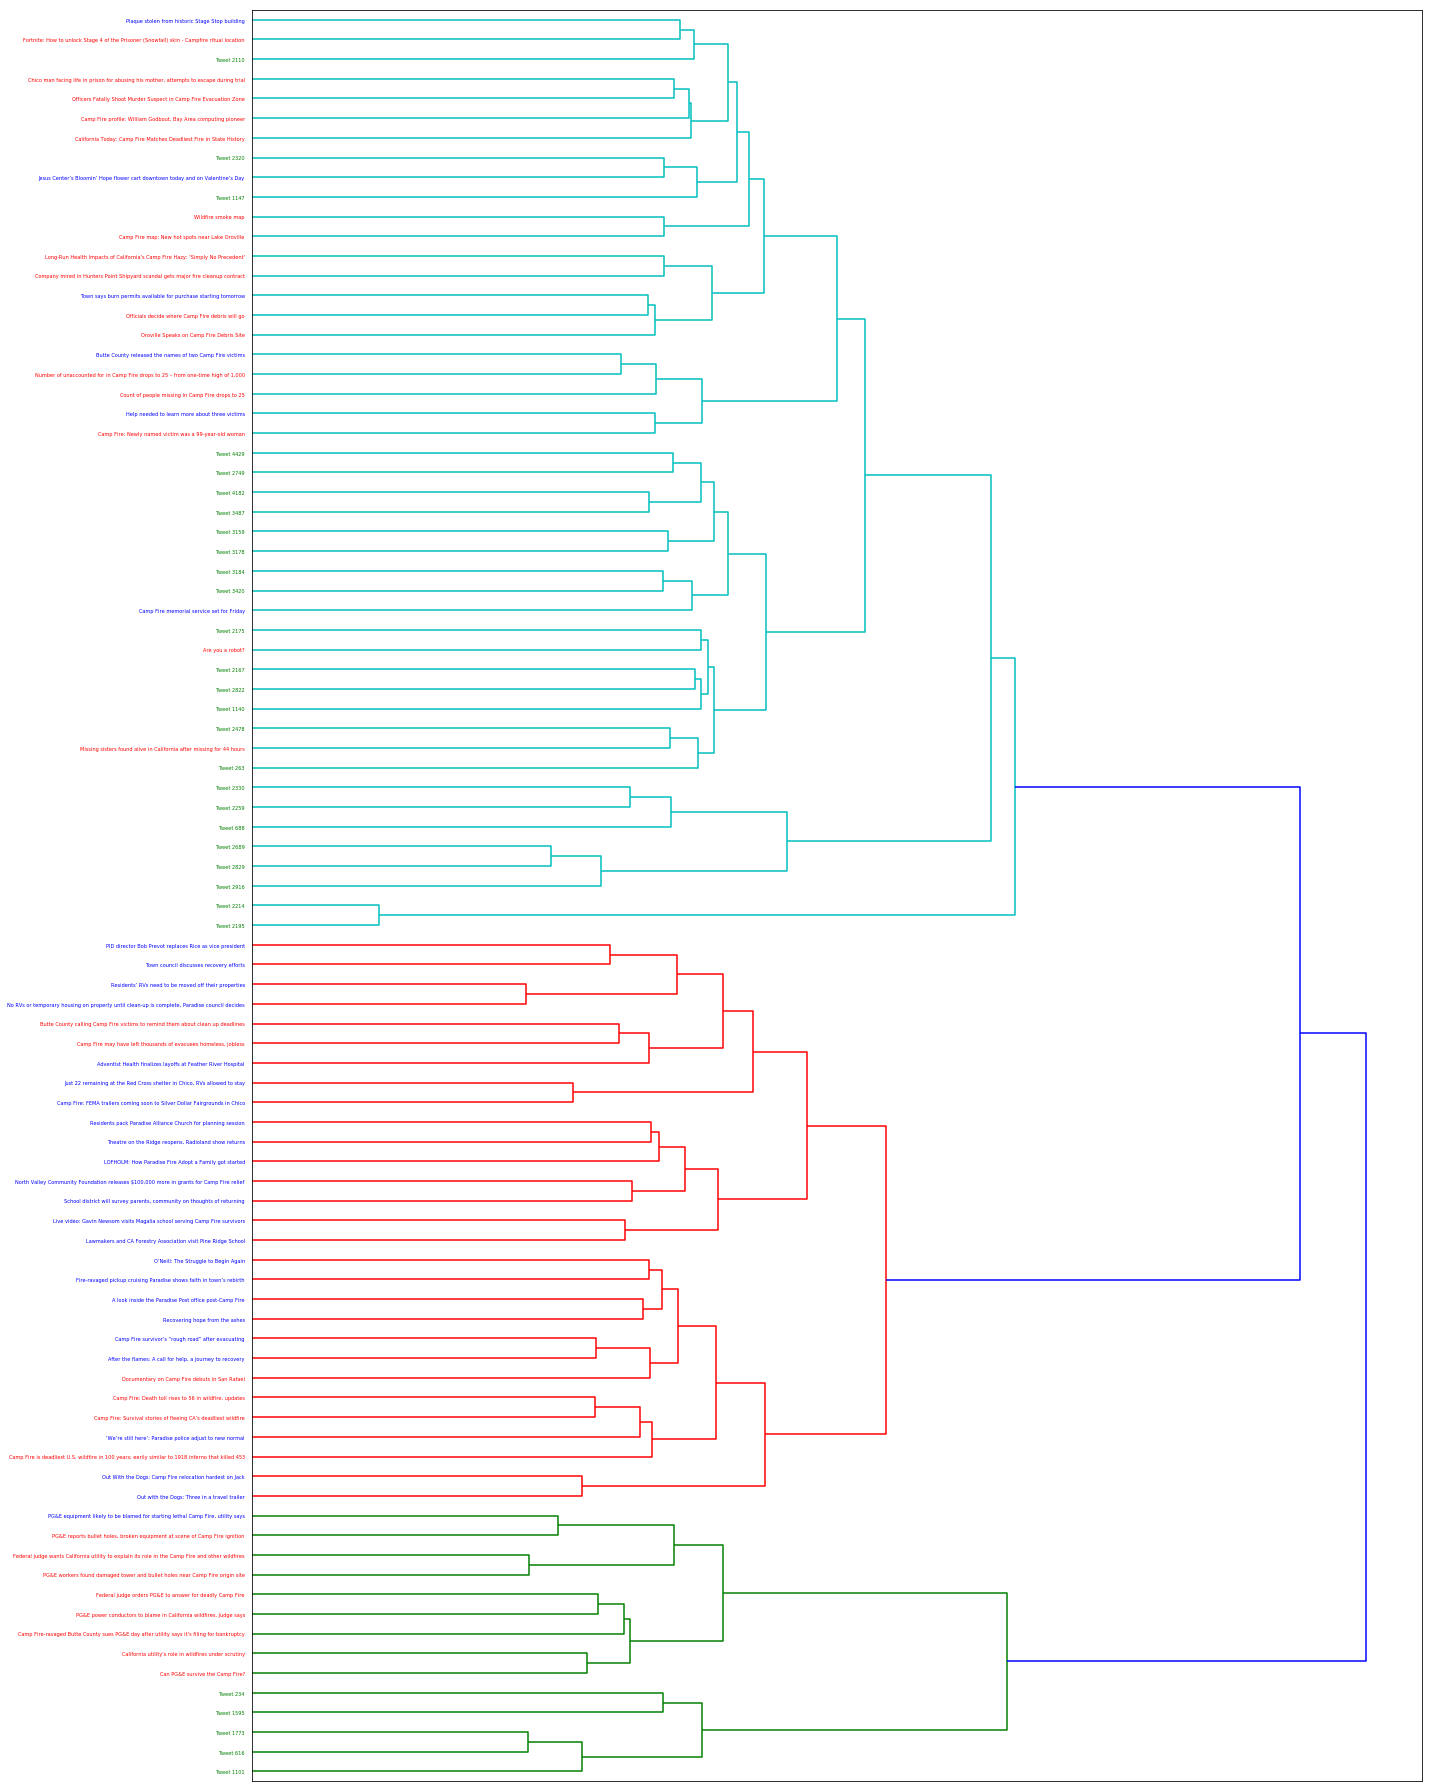

In [376]:
linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(20,25)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=nodupe_sample['title']);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)

#https://stackoverflow.com/questions/41597673/how-do-i-format-axis-ticks-to-be-a-certain-color-based-on-sign?noredirect=1&lq=1
#https://stackoverflow.com/questions/14802048/scipy-dendrogram-leaf-label-colours
label_colors = {'Google News': 'r', 'Twitter': 'g', 'Local': 'b'}

ax = plt.gca()
ylbls = ax.get_ymajorticklabels()
for lbl in ylbls:
    category = nodupe_sample[nodupe_sample['title'] == lbl.get_text()]
   # print(list(category['source'])[0])
    lbl.set_color(label_colors[list(category['source'])[0]])



plt.tight_layout() #show plot with tight layout

In [431]:
def clean_doc(text):
    """
    Performs basic corpus cleaning by performing tokenization, lowercasing, removing non-words
    removing stop-words, and lemmatizing. Returns a list of the cleaned text
    
    text: an article as described in Excercise 1.3
    """
    #Tokenize the words
    words = nltk.word_tokenize(text)

    #https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-list-of-lists
    #Flatten the list of lists
    #words = [item for sublist in words for item in sublist]

    #lowercase words and remove non-words
    lower = [w.lower() for w in words if (re.search("[0-9:\\.`'“’(),”\-@—&;$#!\*\+\?_/]|\\\\u[0-9]+|https|\\bamp\\b|\\brt\\b", w) is None) and re.search("[a-zA-Z]", w)]

    #Init lemmatizer and stopword dict
    lemmatizer = nltk.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words("english")

    #Lemmatize and remove stopwords
    article_tags = nltk.pos_tag(lower)
    cleaned = [lemmatizer.lemmatize(w, wordnet_pos(t)) for (w, t) in article_tags if w not in stopwords]
    return(cleaned)

In [433]:
text = [clean_doc(doc) for doc in nodupe['text']]

In [437]:
nodupe["cleaned"] = text

In [444]:
nodupe.to_csv("cleaned_lemma.csv")

In [413]:
with open('cleaned_lemma.txt', 'w', ) as f:
    for item in cleaned_no_dupes:
        f.write("%s\n" % item)

In [5]:
def load_R_model(filename):
    with open(filename, 'r') as j:
        data_input = json.load(j)
    data = {'topic_term_dists': data_input['phi'], 
            'doc_topic_dists': data_input['theta'],
            'doc_lengths': data_input['doc.length'],
            'vocab': data_input['vocab'],
            'term_frequency': data_input['term.frequency']}
    return data


news_vis_model = load_R_model("vis.JSON")
news_vis_data = pyLDAvis.prepare(**news_vis_model)

pyLDAvis.display(news_vis_data)

c:\users\jon\miniconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [449]:
with open("vis.JSON", 'r') as j:
    data_input = json.load(j)
    
data_input

{'mdsDat': {'x': [0.001218754,
   -0.01778032,
   -0.0155684,
   0.01267311,
   -0.002729099,
   -0.005061504,
   -0.0160111,
   -0.004126046,
   0.004666458,
   0.004353324,
   0.03857568,
   -0.006919672,
   0.01677934,
   0.03410353,
   0.001787015,
   0.02552859,
   -0.01137753,
   -0.05111013,
   -0.003721132,
   0.01496451,
   0.01585114,
   -0.01371219,
   -0.01636481,
   0.008464923,
   0.01386517,
   0.008041103,
   -0.03030326,
   -0.0006082715,
   -0.02314417,
   0.01199326,
   -0.01121293,
   -0.01832231,
   0.007097157,
   0.01697069,
   -0.008369093,
   0.06166048,
   -0.0341774,
   -0.02985427,
   0.02615728,
   -0.004277888],
  'y': [0.01258792,
   0.003650029,
   0.03350468,
   -0.008636594,
   -0.03317784,
   -0.0158187,
   -0.007730937,
   -0.02130241,
   0.02908988,
   -0.005900093,
   -0.0009364048,
   0.0270209,
   0.02227235,
   0.02121135,
   -0.01010519,
   -0.01588763,
   0.006636888,
   0.0004768346,
   0.01485509,
   0.0200539,
   -0.003008547,
   -0.0116408